# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

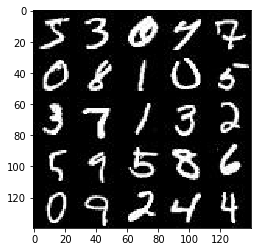

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

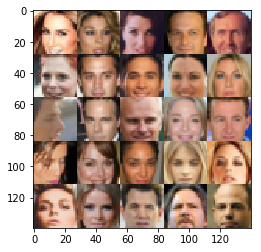

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\Sora\Anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
        
    with tf.variable_scope('discriminator', reuse=reuse):    
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    i = 0  
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)  
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                i += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                
                if i % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                
                if i % 100 ==0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2991... Generator Loss: 2.0402
Epoch 1/2... Discriminator Loss: 0.0325... Generator Loss: 5.2098
Epoch 1/2... Discriminator Loss: 0.0453... Generator Loss: 5.3170
Epoch 1/2... Discriminator Loss: 1.9837... Generator Loss: 10.7393
Epoch 1/2... Discriminator Loss: 0.6308... Generator Loss: 1.8880
Epoch 1/2... Discriminator Loss: 0.2594... Generator Loss: 2.9199
Epoch 1/2... Discriminator Loss: 0.3919... Generator Loss: 3.1340
Epoch 1/2... Discriminator Loss: 0.3920... Generator Loss: 1.9975
Epoch 1/2... Discriminator Loss: 0.1557... Generator Loss: 3.6013
Epoch 1/2... Discriminator Loss: 0.7408... Generator Loss: 5.1353


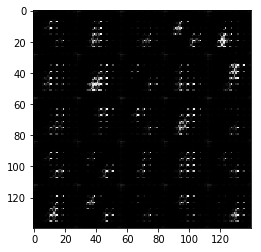

Epoch 1/2... Discriminator Loss: 0.4769... Generator Loss: 1.6097
Epoch 1/2... Discriminator Loss: 0.7542... Generator Loss: 1.2745
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 2.0060... Generator Loss: 5.2029
Epoch 1/2... Discriminator Loss: 0.2710... Generator Loss: 2.6086
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 1.8122
Epoch 1/2... Discriminator Loss: 0.8237... Generator Loss: 0.8993
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 2.1637
Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 0.9028
Epoch 1/2... Discriminator Loss: 0.9557... Generator Loss: 1.4919


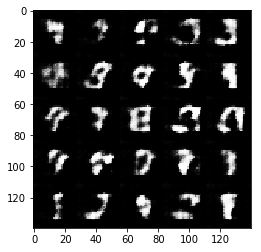

Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 3.8429
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 2.8334
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.5348
Epoch 1/2... Discriminator Loss: 1.8922... Generator Loss: 0.3926
Epoch 1/2... Discriminator Loss: 0.8059... Generator Loss: 1.1376
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.2453
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 0.7545


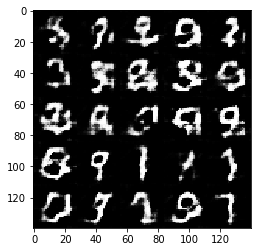

Epoch 1/2... Discriminator Loss: 0.7498... Generator Loss: 2.1575
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.8756
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 1.9152
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.4123
Epoch 1/2... Discriminator Loss: 0.6828... Generator Loss: 1.4266
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.6715
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 0.7368
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 0.8805


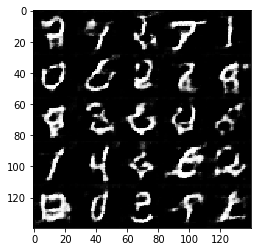

Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 0.7220
Epoch 1/2... Discriminator Loss: 0.9289... Generator Loss: 1.6294
Epoch 1/2... Discriminator Loss: 0.8852... Generator Loss: 1.1643
Epoch 1/2... Discriminator Loss: 0.9309... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 0.7664... Generator Loss: 1.4800
Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 0.7117
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.9686
Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 1.3619
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 1.3418


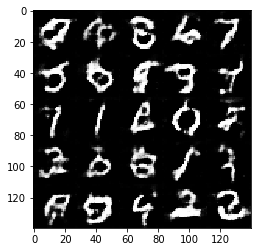

Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 0.8677
Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 1.0423... Generator Loss: 1.5417
Epoch 1/2... Discriminator Loss: 1.0699... Generator Loss: 1.5540
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 1.1710
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 0.6503
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 0.7794
Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 0.5963


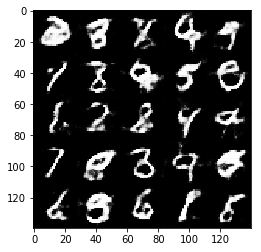

Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 0.8532... Generator Loss: 1.7756
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 0.8046... Generator Loss: 1.2948
Epoch 1/2... Discriminator Loss: 0.9589... Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 0.6726
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.0096
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 0.7523
Epoch 1/2... Discriminator Loss: 0.7872... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 1.0444... Generator Loss: 0.7573


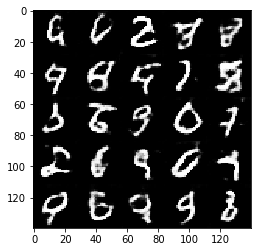

Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 1.3207
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 0.5589
Epoch 1/2... Discriminator Loss: 0.9099... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 2.3216
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 0.9050
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 2.3749
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 0.9248... Generator Loss: 1.5723
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.4484


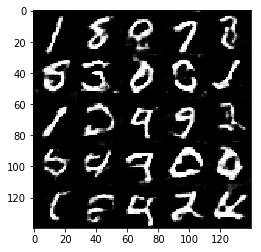

Epoch 1/2... Discriminator Loss: 1.0244... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 0.9951
Epoch 1/2... Discriminator Loss: 0.7357... Generator Loss: 1.2210
Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 1.1732... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 1.7353... Generator Loss: 0.4228
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 0.9836
Epoch 1/2... Discriminator Loss: 0.7493... Generator Loss: 1.4268
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 1.2299
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 1.0739


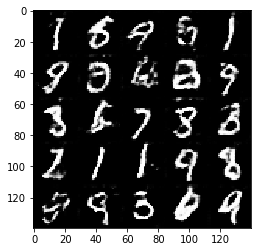

Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 0.7656
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.4033
Epoch 2/2... Discriminator Loss: 0.9150... Generator Loss: 1.5146
Epoch 2/2... Discriminator Loss: 0.9129... Generator Loss: 0.7872
Epoch 2/2... Discriminator Loss: 0.8729... Generator Loss: 1.2348
Epoch 2/2... Discriminator Loss: 0.8088... Generator Loss: 1.0203
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.1633
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 0.8001


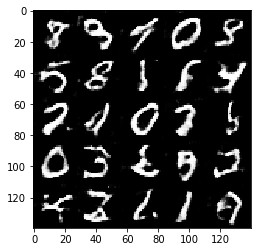

Epoch 2/2... Discriminator Loss: 0.8206... Generator Loss: 1.2538
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 0.9199
Epoch 2/2... Discriminator Loss: 0.9142... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 0.8474
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.2188
Epoch 2/2... Discriminator Loss: 1.6495... Generator Loss: 0.3039
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 1.4748... Generator Loss: 0.3729
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.7578... Generator Loss: 1.0502


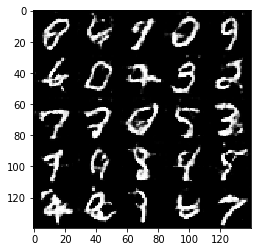

Epoch 2/2... Discriminator Loss: 2.0878... Generator Loss: 3.6578
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 0.7117
Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 1.2855
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 2.2249... Generator Loss: 0.1760
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.5600
Epoch 2/2... Discriminator Loss: 1.2906... Generator Loss: 0.5185
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 0.5147
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 0.8039
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 0.8933


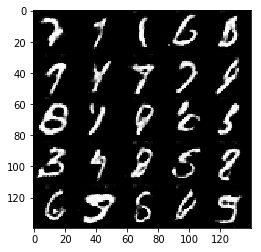

Epoch 2/2... Discriminator Loss: 0.8903... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.7921
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.0262
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 0.7251
Epoch 2/2... Discriminator Loss: 1.1484... Generator Loss: 2.5415
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.4655
Epoch 2/2... Discriminator Loss: 1.2537... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 0.7830... Generator Loss: 2.1673


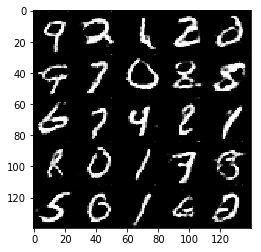

Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.5402
Epoch 2/2... Discriminator Loss: 1.8345... Generator Loss: 0.2979
Epoch 2/2... Discriminator Loss: 0.5548... Generator Loss: 1.7873
Epoch 2/2... Discriminator Loss: 0.6769... Generator Loss: 1.2146
Epoch 2/2... Discriminator Loss: 1.7982... Generator Loss: 0.2920
Epoch 2/2... Discriminator Loss: 0.5955... Generator Loss: 1.7619
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 3.6991
Epoch 2/2... Discriminator Loss: 0.9535... Generator Loss: 0.7376
Epoch 2/2... Discriminator Loss: 0.9038... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.3999


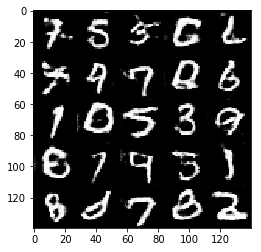

Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.1345
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 3.5531
Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.3231
Epoch 2/2... Discriminator Loss: 0.7342... Generator Loss: 1.0212
Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 1.6888
Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 0.4891
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 0.8368
Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 0.5589
Epoch 2/2... Discriminator Loss: 0.6672... Generator Loss: 1.1556
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 1.2493


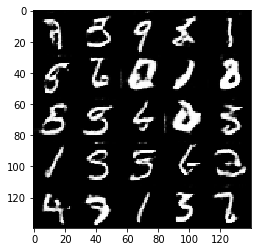

Epoch 2/2... Discriminator Loss: 0.6301... Generator Loss: 1.2387
Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 0.4308... Generator Loss: 1.7116
Epoch 2/2... Discriminator Loss: 0.4821... Generator Loss: 1.6998
Epoch 2/2... Discriminator Loss: 1.7997... Generator Loss: 0.3826
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 1.6405
Epoch 2/2... Discriminator Loss: 0.8270... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 0.7296... Generator Loss: 0.9262
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 2.0532
Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 1.4858


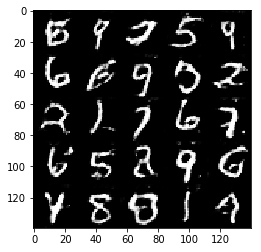

Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 1.9615
Epoch 2/2... Discriminator Loss: 0.7239... Generator Loss: 1.0005
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 1.1273
Epoch 2/2... Discriminator Loss: 1.9765... Generator Loss: 0.2228
Epoch 2/2... Discriminator Loss: 0.6313... Generator Loss: 1.0438
Epoch 2/2... Discriminator Loss: 0.6858... Generator Loss: 1.2965
Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 0.9648
Epoch 2/2... Discriminator Loss: 0.5531... Generator Loss: 1.2227
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.6202
Epoch 2/2... Discriminator Loss: 1.5587... Generator Loss: 0.3661


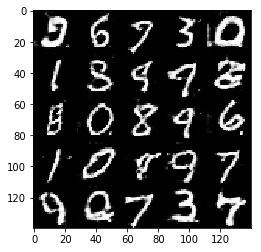

Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 2.2299
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 0.6006
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 1.6555
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 0.5121... Generator Loss: 1.9810
Epoch 2/2... Discriminator Loss: 0.5111... Generator Loss: 1.3592
Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 0.7333
Epoch 2/2... Discriminator Loss: 1.0656... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 0.4175... Generator Loss: 1.8177
Epoch 2/2... Discriminator Loss: 1.7414... Generator Loss: 0.3862


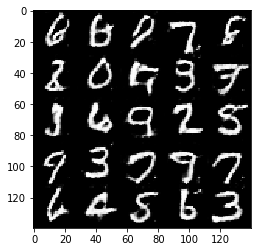

Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.0446
Epoch 2/2... Discriminator Loss: 0.7041... Generator Loss: 1.2495
Epoch 2/2... Discriminator Loss: 0.9852... Generator Loss: 0.7493
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 0.6951... Generator Loss: 1.1595
Epoch 2/2... Discriminator Loss: 0.6558... Generator Loss: 1.2975
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 0.7601


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.9396... Generator Loss: 0.0828
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 2.0182... Generator Loss: 0.1816
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 6.2903
Epoch 1/1... Discriminator Loss: 0.2764... Generator Loss: 3.1135
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 7.3818
Epoch 1/1... Discriminator Loss: 0.2941... Generator Loss: 2.3268
Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 6.9542
Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 5.5157
Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 2.8134


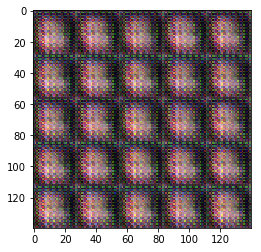

Epoch 1/1... Discriminator Loss: 0.1704... Generator Loss: 2.7694
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 1.8205
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 0.2560... Generator Loss: 4.0443
Epoch 1/1... Discriminator Loss: 0.2599... Generator Loss: 2.2460
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 1.4083
Epoch 1/1... Discriminator Loss: 0.1505... Generator Loss: 2.8052
Epoch 1/1... Discriminator Loss: 0.2153... Generator Loss: 2.2687


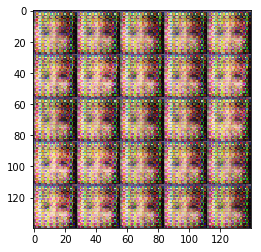

Epoch 1/1... Discriminator Loss: 0.5856... Generator Loss: 1.6260
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 2.8099
Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 2.2894
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 2.1635
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.2889
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 0.7865


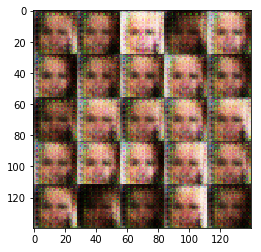

Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 2.2625


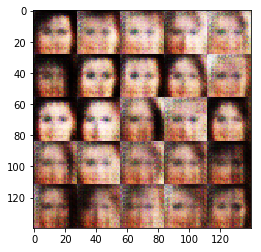

Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 0.3427
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 1.7612... Generator Loss: 0.3136
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.3722
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.7035... Generator Loss: 0.3037
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 0.8159


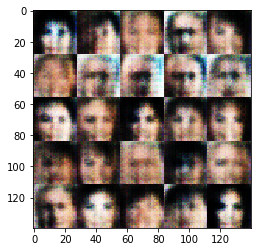

Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 2.3476
Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.9287
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.6237... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.7722... Generator Loss: 0.2405
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.7794


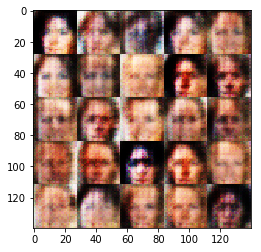

Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.5183
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 1.7791
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 2.0412
Epoch 1/1... Discriminator Loss: 1.6498... Generator Loss: 0.3123
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 2.1582... Generator Loss: 0.1701
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 2.4490


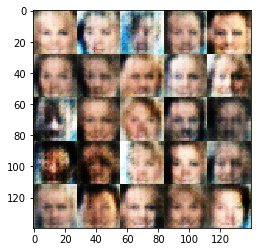

Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 2.2505
Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.5793


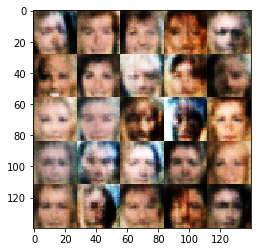

Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.3269
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 2.1090
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.6458
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 2.2839
Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.7365
Epoch 1/1... Discriminator Loss: 1.5687... Generator Loss: 0.3196
Epoch 1/1... Discriminator Loss: 1.7418... Generator Loss: 0.2591


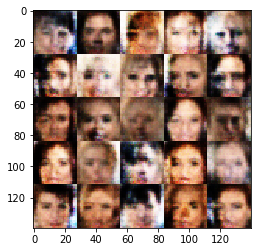

Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 1.8076
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 1.9022
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.2983
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 0.9073


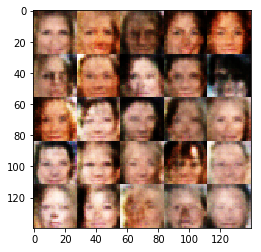

Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 1.4104


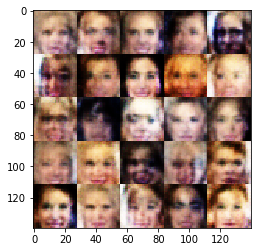

Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 1.4796
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.7708
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.9681... Generator Loss: 0.1993
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 1.7918


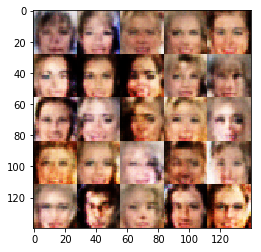

Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.8389... Generator Loss: 0.2201
Epoch 1/1... Discriminator Loss: 2.4549... Generator Loss: 0.1236
Epoch 1/1... Discriminator Loss: 1.9617... Generator Loss: 0.2125
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 2.2953
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 3.2529


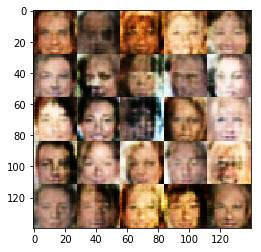

Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.4074
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.3171
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 2.0700
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 3.4987
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 3.6837
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 1.3110


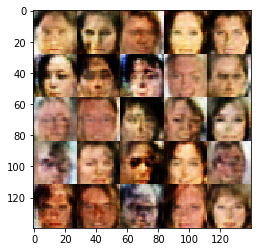

Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 2.6126
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 1.6440
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 1.4970
Epoch 1/1... Discriminator Loss: 2.4986... Generator Loss: 0.1153
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.6869


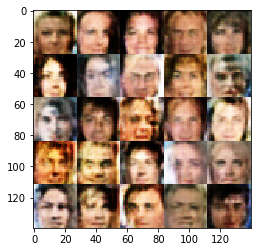

Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.3077
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.5833
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.3345
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.2772


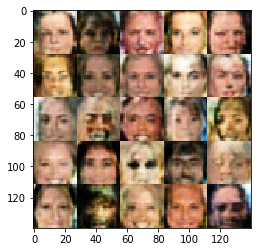

Epoch 1/1... Discriminator Loss: 0.5574... Generator Loss: 1.7114
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 3.7994
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 2.2369
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.3950
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 1.6382
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.6858


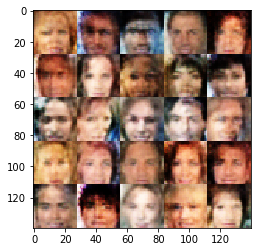

Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.3191
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.2297
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.9307


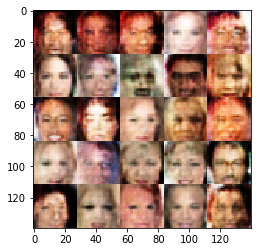

Epoch 1/1... Discriminator Loss: 1.8468... Generator Loss: 0.2217
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 1.9027... Generator Loss: 0.2315


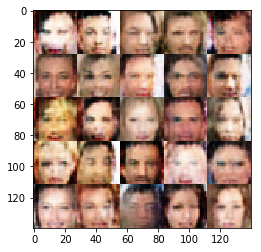

Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.9891


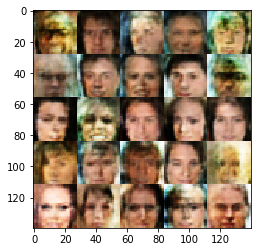

Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.6885


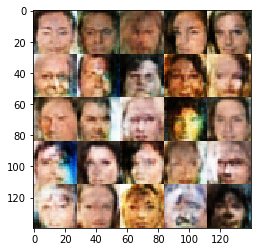

Epoch 1/1... Discriminator Loss: 0.7223... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.8259... Generator Loss: 0.2322
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 3.0458
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.7379... Generator Loss: 0.2481
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.4660
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.5957
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 1.6168


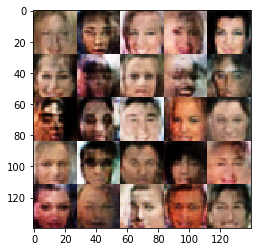

Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.6346... Generator Loss: 0.2897
Epoch 1/1... Discriminator Loss: 1.8365... Generator Loss: 0.2172
Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 2.1183
Epoch 1/1... Discriminator Loss: 1.8493... Generator Loss: 0.2096
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.3564
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 1.7506


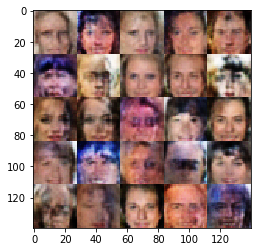

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.2769
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.3186
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.3159
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.5379


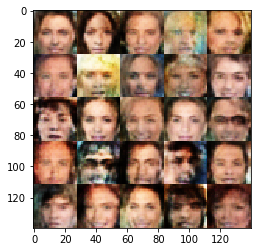

Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.3828
Epoch 1/1... Discriminator Loss: 1.9663... Generator Loss: 0.1943
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.4172
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.3763
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 0.8541


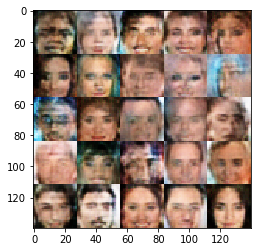

Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.5543
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.5853
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.3580
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 2.0263... Generator Loss: 2.2380


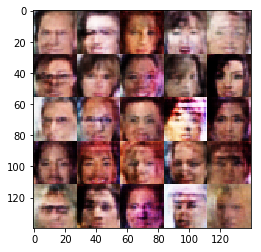

Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.8692... Generator Loss: 0.2061
Epoch 1/1... Discriminator Loss: 2.6593... Generator Loss: 0.0901
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.5159
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.3353
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.5115


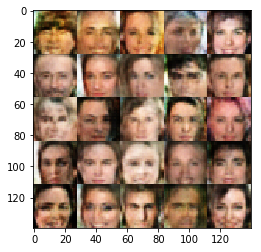

Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.7419
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 2.1375... Generator Loss: 0.1776
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 1.8720
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.1328


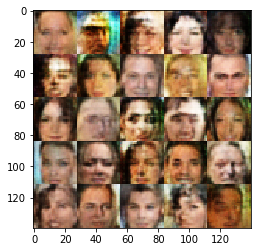

Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.8186
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.8059


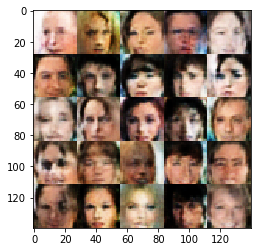

Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 2.6349
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 1.4805
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.3399
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.7075... Generator Loss: 0.2701


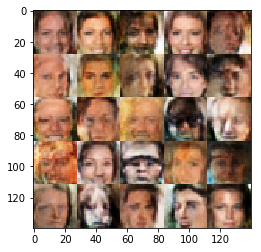

Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.4155
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.4029
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 0.6713


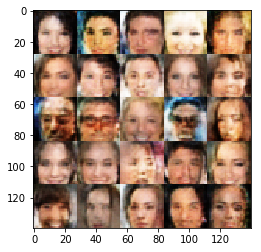

Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.3560
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.2024
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.3653
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.3091


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.